In [9]:
import numpy as np
from gymnasium import Env
from gymnasium import spaces
from gymnasium.spaces import Discrete, Box
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [10]:
def generate_time_series(batch_size: int, 
                         n_steps: int) -> torch.Tensor:
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # 4, 32, 1
    time = np.linspace(0, 1, n_steps) # 50
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # 50
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # 50
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # 32, 50
    return torch.from_numpy(series[..., np.newaxis].astype(np.float32)) # 32, 50, 1

In [11]:
n_steps = 50
series = generate_time_series(10_000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

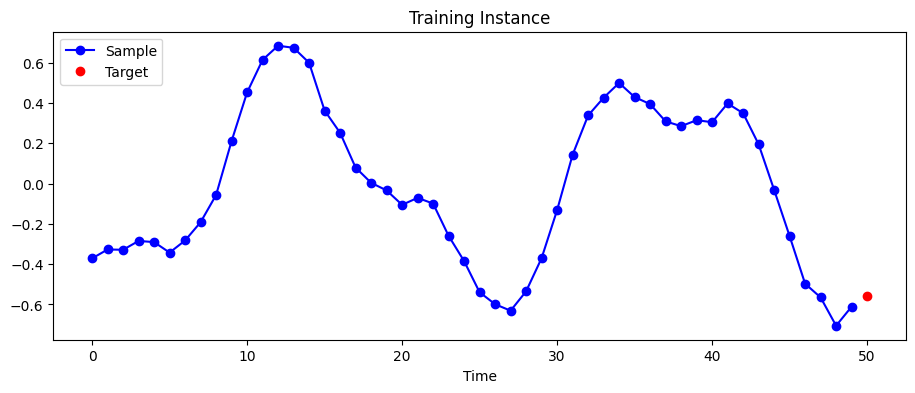

In [12]:
# Plotting the training data
plt.figure(figsize=(11,4))
plt.plot(np.arange(n_steps), X_train[0, ...], "bo-", label="Sample")
plt.plot(np.arange(n_steps, n_steps + 1), y_train[0, ...], "ro", label="Target")
plt.title("Training Instance")
plt.xlabel("Time")
plt.legend(loc="upper left")

In [14]:
class RNN(nn.Module):
    def __init__(self, 
                 input_size: int,
                 output_size: int, 
                 hidden_dim: int,
                 n_layers: int) -> None:
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # Many inputs to one output
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_dim)

In [15]:
model = RNN(input_size=1, output_size=1, hidden_dim=32, n_layers=1)